In [ ]:
# Блок 0. Установка библиотек (запускается ОДИН раз)
!pip install -q kaggle tensorflow pandas numpy matplotlib seaborn plotly scikit-learn kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Блок 1. Импорт библиотек
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from sklearn.model_selection import train_test_split #разделение данных
from sklearn.preprocessing import StandardScaler #нормализация данных
from sklearn.metrics import ( # Метрики оценки моделей
    classification_report,  # Отчет по классификации
    confusion_matrix,   # Матрица ошибок
    roc_auc_score,    # ROC-AUC метрика
    roc_curve,    # ROC кривая
    precision_recall_curve   # Кривая Precision-Recall
)

import plotly.graph_objects as go   # Низкоуровневые графики
import plotly.express as px  # Высокоуровневые графики
from plotly.subplots import make_subplots  # Множественные графики

from IPython.display import HTML, display

import warnings
warnings.filterwarnings("ignore")

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
# === Новый Блок 2. Прямое чтение файла из сессии ===
import pandas as pd

csv_path = "/earthquake_data_tsunami.csv"
df = pd.read_csv(csv_path)

print("Размерность df:", df.shape)
display(df.head()) #просмотр первых 5 строк таблицы


Размерность df: (782, 13)


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [ ]:
# ============================================================
# Блок 3. Загрузка и предварительная обработка данных
# ============================================================

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

csv_path = "/earthquake_data_tsunami.csv"

print("Используем файл:", csv_path)

# 2) Читаем CSV
df = pd.read_csv(csv_path)
print("Размерность df:", df.shape)
display(df.head())

# 3) Целевая переменная
target_col = "tsunami"
assert target_col in df.columns, "В датасете нет столбца 'tsunami'"

# 4) Удаляем пропуски
df = df.dropna().reset_index(drop=True)
print("После удаления пропусков:", df.shape)

# 5) Разделяем признаки и цель
X = df.drop(columns=[target_col])
y = df[target_col].astype(int) #на случай если метки в строковом формате

print("Признаки:", list(X.columns))
print("Классы (0 - без цунами, 1 - цунами):")
print(y.value_counts(normalize=True)) #показывает процентное соотношение

# 6) Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7) Train / Val / Test
# Первое разделение: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
# Второе разделение: 15% val, 15% test (от исходных данных)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Используем файл: /earthquake_data_tsunami.csv
Размерность df: (782, 13)


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


После удаления пропусков: (782, 13)
Признаки: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month']
Классы (0 - без цунами, 1 - цунами):
tsunami
0    0.611253
1    0.388747
Name: proportion, dtype: float64
Train: (547, 12) Val: (117, 12) Test: (118, 12)


In [ ]:
# Блок 4. Параметры модели (полная параметризация)
# ============================================================

config = {
    "input_dim": X_train.shape[1],    # Количество признаков на входе
    "hidden_layers": [64, 64, 32],    # Три скрытых слоя с 64, 64 и 32 нейронами
    "hidden_activation": "relu",      # Функция активации для скрытых слоев
    "output_activation": "sigmoid",   # Сигмоида для бинарной классификации
    "l2_reg": 1e-4,                         # L2-регуляризация
    "dropout_rate": 0.3,   # 30% нейронов отключаются случайно
    "batch_norm": True,   # Batch Normalization после каждого слоя
    "optimizer": "adam",  # Алгоритм оптимизации
    "learning_rate": 1e-3,  # Скорость обучения (0.001)
    "batch_size": 32,  # Размер мини-батча
    "epochs": 50,  # Максимальное количество эпох
    "early_stopping_patience": 8,  # Остановка после 8 эпох без улучшений
    "lr_reduce_factor": 0.5,   # Уменьшение LR в 2 раза
    "lr_reduce_patience": 4  # Уменьшение LR после 4 эпох без улучшений
}

config


{'input_dim': 12,
 'hidden_layers': [64, 64, 32],
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'l2_reg': 0.0001,
 'dropout_rate': 0.3,
 'batch_norm': True,
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'batch_size': 32,
 'epochs': 50,
 'early_stopping_patience': 8,
 'lr_reduce_factor': 0.5,
 'lr_reduce_patience': 4}

In [ ]:
# Блок 5. Функция построения модели
# ============================================================

def build_dense_model(cfg):
    inputs = keras.Input(shape=(cfg["input_dim"],), name="input")  #создает входной тензор
    x = inputs
# Цикл по всем скрытым слоям, указанным в конфигурации. enumerate возвращает индекс (i) и количество нейронов (units)
    for i, units in enumerate(cfg["hidden_layers"]):
        # добавление полносвязанного слоя
        x = layers.Dense(
            units,
            activation=None,
            kernel_regularizer=regularizers.l2(cfg["l2_reg"]),
            name=f"dense_{i+1}"
        )(x)
        # Условное добавление Batch Normalization слоя: Проверяем флаг batch_norm в конфигурации - BatchNorm нормализует выход предыдущего слоя (стабильность обучения)
        if cfg["batch_norm"]:
            x = layers.BatchNormalization(name=f"bn_{i+1}")(x)
        x = layers.Activation(cfg["hidden_activation"], name=f"act_{i+1}")(x)# Добавление слоя активации отдельно
        x = layers.Dropout(cfg["dropout_rate"], name=f"drop_{i+1}")(x) # Добавление Dropout слоя для регуляризации:
    # Добавление выходного слоя: 1 нейрон для бинарной классификации
    outputs = layers.Dense(
        1,
        activation=cfg["output_activation"],
        name="output"
    )(x)
    # Создание модели Keras на основе входов и выходов:
    model = keras.Model(inputs=inputs, outputs=outputs, name="tsunami_risk_dense_model")

    # Явное создание оптимизатора Adam
    opt = keras.optimizers.Adam(learning_rate=cfg["learning_rate"])
    # Компиляция модели (подготовка к обучению)
    model.compile(
        optimizer=opt,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model
# Создание экземпляра модели, используя конфигурационный словарь config
model = build_dense_model(config)
model.summary()


Model: "tsunami_risk_dense_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_1 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_2 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_2 (Dropout)                │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ act_3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_3 (Dropout)                │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,745 (30.25 KB)

 Trainable params: 7,425 (29.00 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# Блок 6. Колбэки (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
# ============================================================
# Определение пути для сохранения лучшей версии модели
checkpoint_path = "best_tsunami_model.keras"

callbacks = [
    # 1. EarlyStopping - досрочная остановка обучения
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=config["early_stopping_patience"],
        restore_best_weights=True, # Автоматически восстанавливает веса лучшей эпохи
        verbose=1  # Вывод сообщений в консоль (1 = вывод включен)
    ),
    # 2. ReduceLROnPlateau - уменьшение learning rate при застое
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=config["lr_reduce_factor"],
        patience=config["lr_reduce_patience"],
        verbose=1
    ),
    # 3. ModelCheckpoint - сохранение модели на диск
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, # Путь для сохранения файла модели
        monitor="val_loss",
        save_best_only=True,# Сохранять только модель с лучшим значением monitor
        verbose=1
    )
]


In [ ]:
# Блок 7. Обучение модели
# ============================================================
# model.fit() - основной метод обучения в Keras
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config["epochs"],  #максимальное количество проходов по всему тренировочному набору
    batch_size=config["batch_size"], #количество примеров, обрабатываемых за один шаг
    callbacks=callbacks, #список функций, вызываемых в процессе обучения
    shuffle=True
    verbose=1
)

# Загружаем лучшую сохранённую модель
best_model = keras.models.load_model(checkpoint_path)


Epoch 1/50
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5140 - loss: 0.8949
Epoch 1: val_loss improved from inf to 0.64680, saving model to best_tsunami_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5281 - loss: 0.8698 - val_accuracy: 0.7692 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 2/50
13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6852 - loss: 0.5986 
Epoch 2: val_loss improved from 0.64680 to 0.57647, saving model to best_tsunami_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6852 - loss: 0.6018 - val_accuracy: 0.7949 - val_loss: 0.5765 - learning_rate: 0.0010
Epoch 3/50
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7355 - loss: 0.6247 
Epoch 3: val_loss improved from 0.57647 to 0.53187, saving model to best_tsunami_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7437 - loss: 0.6072 - val_accuracy: 0.8376 - val_loss: 0.5319 - learning_rate: 0.0010
Epoch 4/50
14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

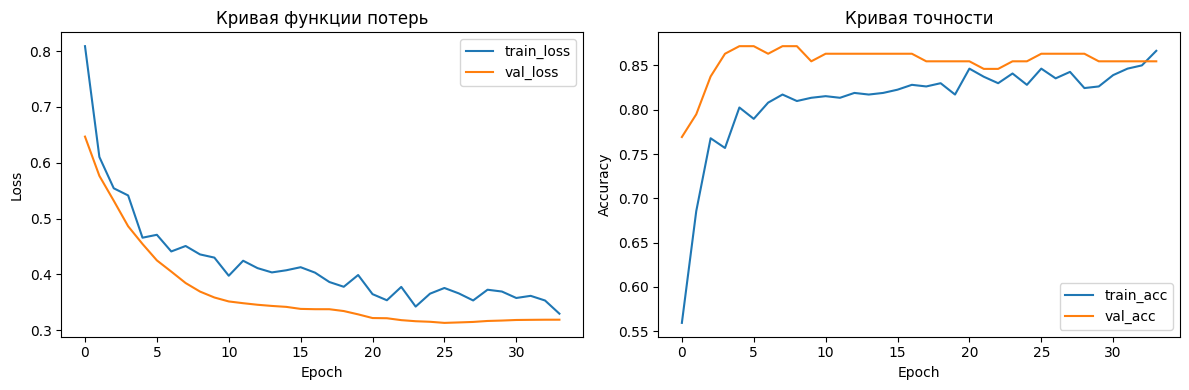

In [ ]:
# Блок 8. Графики: Loss/Accuracy
# ============================================================

hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 4))  #Создаем новую фигуру (окно для графиков)
plt.subplot(1, 2, 1)  # Создаем первый график
plt.plot(hist_df["loss"], label="train_loss") # Рисуем кривую потерь на тренировочных данных
plt.plot(hist_df["val_loss"], label="val_loss")  # Рисуем кривую потерь на валидационных данных
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Кривая функции потерь")
plt.legend()

plt.subplot(1, 2, 2)  # Создаем второй график
plt.plot(hist_df["accuracy"], label="train_acc")  # Рисуем кривую accuracy на тренировочных данных
plt.plot(hist_df["val_accuracy"], label="val_acc")  # Рисуем кривую accuracy на валидационных данных
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Кривая точности")
plt.legend()

plt.tight_layout() # Автоматически настраиваем отступы между графиками чтобы они не перекрывались
plt.show()  # Отображаем все графики


In [ ]:
# Блок 9. Оценка на тестовой выборке + ROC / PR
# ============================================================
# Получаем вероятностные предсказания модели на тестовых данных best_model.predict(X_test) возвращает массив формы (n_samples, 1).ravel() преобразует в одномерный массив формы (n_samples,)
y_pred_proba = best_model.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)  # Преобразуем вероятности в бинарные предсказания (0 или 1) порог отсечения по умолчанию: 0.5

print("Classification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred) # Вычисляем и выводим матрицу ошибок (confusion matrix)
print("Confusion matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_proba) # Вычисляем ROC-AUC (Area Under ROC Curve) ROC-AUC показывает, насколько хорошо модель различает классы 1.0 - идеально, 0.5 - как случайное угадывание
print("ROC-AUC:", roc_auc)

# ROC-кривая
fpr, tpr, thr = roc_curve(y_test, y_pred_proba)
# PR-кривая
prec, rec, thr_pr = precision_recall_curve(y_test, y_pred_proba)
# Создаем интерактивные графики с двумя подграфиками
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("ROC-кривая", "Precision-Recall кривая")
)
# Добавляем ROC-кривую на первый график
fig.add_trace(
    go.Scatter(x=fpr, y=tpr, mode="lines", name=f"ROC (AUC={roc_auc:.3f})"),
    row=1, col=1
)
# Добавляем диагональную линию (случайная модель) на ROC-график
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], mode="lines", name="Случайная модель", line=dict(dash="dash")),
    row=1, col=1
)
# Добавляем Precision-Recall кривую на второй график
fig.add_trace(
    go.Scatter(x=rec, y=prec, mode="lines", name="PR-кривая"),
    row=1, col=2
)
# Настраиваем подписи осей для ROC-графика
fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
# Настраиваем подписи осей для PR-графика
fig.update_xaxes(title_text="Recall", row=1, col=2)
fig.update_yaxes(title_text="Precision", row=1, col=2)
# Настраиваем общий вид графика
fig.update_layout(height=400, width=900, title_text="Качество модели")
fig.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84        72
           1       0.72      0.89      0.80        46

    accuracy                           0.82       118
   macro avg       0.82      0.83      0.82       118
weighted avg       0.84      0.82      0.82       118

Confusion matrix:
[[56 16]
 [ 5 41]]
ROC-AUC: 0.8879830917874396


In [ ]:
# Блок 10. Интерпретация важности признаков (по чувствительности)
# ============================================================

# Оценим, как изменение каждого признака влияет на вероятность цунами
feature_names = X.columns
baseline_input = X_test.mean(axis=0)  # среднее по тесту
# Функция анализа чувствительности
def sensitivity_analysis(model, baseline, feature_names, delta=0.5):
    sens = []  # Список для хранения результатов
    baseline = baseline.reshape(1, -1)  # Преобразуем в 2D массив
    base_pred = model.predict(baseline)[0, 0]  # Базовое предсказание


    for i, name in enumerate(feature_names):  # Копируем базовый пример для каждого признака
        x_plus = baseline.copy()
        x_minus = baseline.copy()
        # Увеличиваем и уменьшаем i-й признак
        x_plus[0, i] += delta
        x_minus[0, i] -= delta
        # Получаем предсказания для измененных примеров
        p_plus = model.predict(x_plus)[0, 0]
        p_minus = model.predict(x_minus)[0, 0]
        # Оцениваем градиент (влияние признака)
        grad_est = (p_plus - p_minus) / (2 * delta)
        sens.append((name, grad_est))
    # Сортируем по абсолютному влиянию (от большего к меньшему)
    sens = sorted(sens, key=lambda x: abs(x[1]), reverse=True)
    return sens, base_pred
# Запускаем анализ
sens, base_pred = sensitivity_analysis(best_model, baseline_input, feature_names)
print("Базовая вероятность цунами для среднего события:", base_pred)
sens[:10]
# Создаем DataFrame для визуализации
sens_df = pd.DataFrame(sens, columns=["feature", "sensitivity"])
# Строим столбчатую диаграмму
fig = px.bar(
    sens_df,
    x="feature",
    y="sensitivity",
    title="Оценка чувствительности модели к признакам",
)
# Настраиваем подписи осей
fig.update_layout(xaxis_title="Признак", yaxis_title="Чувствительность")
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Базовая вероятность цунами для среднего события: 0